# To Recap
[The previous blog post](https://wijama.org/2023/12/15/Li-Keqiang-Index-Introduction-and-EDA.html) introduced the project and performed an EDA on data related to the Li Keqiang index which raised some important concerns. Because of our EDA, we chose to perform our analysis using the logged forms of our main variables of interest: GDP, rail cargo volume, and electricity consumption. (Bank loan volume had been omitted from the analysis because no reliable data exists.) We also noticed that there was autocorrelation within countries, which would have to be dealt with. Finally, we noticed problems with our data set in general, which will be discussed at the end of this analysis.

# Model Building
The goal of this analysis was to see if rail cargo volume and electricity consumption are good estimators of GDP. I also wanted to see if this would be impacted by economic variables such as the percentage of the population in urban areas and the percentage of the economy made up of the service sector. I also wanted to see if this would be impacted by the strength of democracy in the country of interest. I expected countries with lower levels of democracy to be more likely to overreport their GDP.
To this end, I built two models: one with just the variables of interest and one that included interactions between my control variables and the economic indicators. Using the statsmodels formula API, the first model is:
```
log_GDP ~ log_energy_cons+log_rail_cargo
```
And the second model is:
```
log_GDP ~ (log_energy_cons+log_rail_cargo)*(urban_per+service_per+democracy)-(urban_per+service_per+democracy)
```
`urban_per`, `service_per` and `democracy` are removed from the model because I am only interested in how they change the effect of the two economic indicators.

# Model Fitting

Before we begin, you can follow along by downloading the code for this part of the project [here](https://github.com/WiJaMa/stat386-project/blob/main/project_analysis.ipynb).

### Preparing Data and Packages
First, I imported the packages we'll need for the analysis:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.compat import lzip
import statsmodels.stats.api as sms

from statsmodels.stats.diagnostic import het_breuschpagan

import seaborn as sns

Then, I imported the data we produced in the previous blog post:

In [2]:
df = pd.read_csv('keqiang.csv')
# Some of our names kinda suck so let's fix them
df.rename(columns={'Democracy Index': 'democracy'},inplace = True)
# this makes all of our quantitative vars lowercase, our qualitative ones capitalized, and y var in ALL CAPS

# as mentioned in EDA post, we also need to logarithm energy_cons, rail_cargo, and GDP.
df['GDP'] = [math.log(item) for item in df['GDP']]
df['rail_cargo'] = [math.log(item) for item in df['rail_cargo']]
df['energy_cons'] = [math.log(item) for item in df['energy_cons']]
df.rename(columns={'energy_cons': 'log_energy_cons',
                   'rail_cargo': 'log_rail_cargo',
                   'GDP': 'log_GDP'},inplace = True)
df.head()

,Country,Year,Region,democracy,log_energy_cons,log_rail_cargo,urban_per,service_per,log_GDP
0,Canada,2019,North America,9.22,6.304906,13.008256,81.482,67.671163,28.187045
1,United States,2019,North America,7.96,8.291391,14.672950,82.459,77.181114,30.693523
2,Austria,2019,Western Europe,8.29,4.228670,9.986725,58.515,63.129879,26.820488
3,Finland,2019,Western Europe,9.25,4.431378,9.236982,85.446,60.194782,26.316172
4,France,2019,Western Europe,8.12,6.104842,10.430967,80.709,70.043587,28.634909


### Ordinary Least Squares
First, I wanted to try an oridinary least squares model to see if there was anything I needed to fix. I started with a model that just looks at the variables of interest:

In [3]:
#fit regression model
fit = smf.ols('log_GDP ~ log_energy_cons+log_rail_cargo', data=df).fit()

#view model summary
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:                log_GDP   R-squared:                       0.882
Model:                            OLS   Adj. R-squared:                  0.881
Method:                 Least Squares   F-statistic:                     3046.
Date:                Sun, 17 Dec 2023   Prob (F-statistic):               0.00
Time:                        18:33:04   Log-Likelihood:                -829.49
No. Observations:                 820   AIC:                             1665.
Df Residuals:                     817   BIC:                             1679.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          22.0179      0.090    2

One thing I notice here is that while both energy consumption and rail cargo volume are significant here, rail cargo actually has a *negative* effect on GDP rather than a positive one. In the pair plots from the previous post, both rail cargo and energy consumption were positively correlated with GDP. This means that once energy consumption has been accounted for, higher rail cargo volume is actually a very weak indicator of economic success and is actually a *negative* indicator at that. This makes some sense if we reason through it. In a modern service-oriented economy, increased rail cargo volume indicates that the economy is still largely industrial, and thus not as productive.

Next, I tried a model that uses the control variables as interactions.

In [4]:
#fit regression model
fit = smf.ols("log_GDP ~ (log_energy_cons+log_rail_cargo)*(urban_per+service_per+democracy)-(urban_per+service_per+democracy)", data=df).fit()

#view model summary
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:                log_GDP   R-squared:                       0.923
Model:                            OLS   Adj. R-squared:                  0.922
Method:                 Least Squares   F-statistic:                     1217.
Date:                Sun, 17 Dec 2023   Prob (F-statistic):               0.00
Time:                        18:33:04   Log-Likelihood:                -652.94
No. Observations:                 820   AIC:                             1324.
Df Residuals:                     811   BIC:                             1366.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

In this model, the pattern remains, and in fact rail cargo volume is an even larger detriment to economy size than before. The only variables not significant at a p <0.05 level are the interactions that rail cargo volume has with percent of GDP from services and level of democracy. This is counterintuitive. We would expect the GDP in economies with higher contributions from services to be noticably harder to predict using rail cargo volume; that is, we would expect the interaction to make the effect of rail cargo volume smaller. However, this is not the case; in fact, the coefficient suggests that if anything, it is making the negative effect of rail cargo volume greater. It seems that in large service industries, higher rail cargo volumne could indicate that more money is being spent on transportation of goods (a low value-add) which is a detriment to the GDP.

Also unusually, the results seem to suggest that weaker democracies and authoritarian states are not inflating their GDP. If they were, we would expect the cumulative effect of the democracy interactions to be negative---that is, in democracies, the same level of energy consumption would predict a smaller economy than it would in an authoritarian country. However, the opposite is true: a 1-point increase in Democracy Index results in a 0.0235 increase in log(GDP). This suggests that democracies themselves are either inflating their GDP (not likely, because parties outside power have an incentive to point out false economic statistics to delegitimize their opponents) or they have intrinsically stronger economies.

Our model accounts for 92.2% of the variability in our data, which is very good. The lower AIC of this model suggests that the interaction variable are a significant improvement over the previous model which just had the two variables of interest.

Let's look at the a plot of residuals and fitted values to see if there are likely to be any problems we need to resolve.

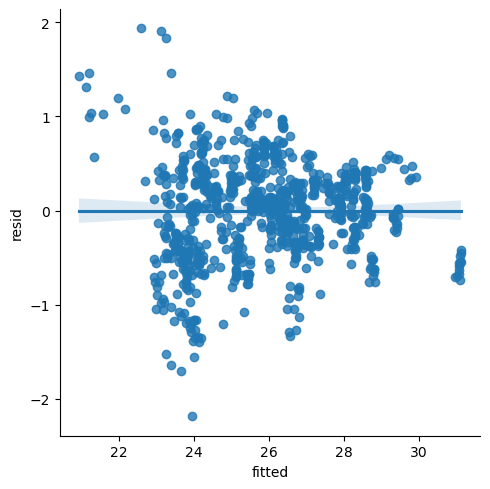

In [5]:
df['fitted'] = fit.fittedvalues
df['resid'] = fit.resid
sns.lmplot(data = df, x = 'fitted', y = 'resid')
plt.show()

The fit looks linear, and our correlation is very, very high, which is good. However, there is also heteroskedasticity---that is, the variance of our residuals is not constant across our fitted values. This is a problem because it means that our standard errors will be incorrect. Since we've already done the transforms that I would have tried for resolving this, we need to fit a model that accounts for this. Let's also check for normality.

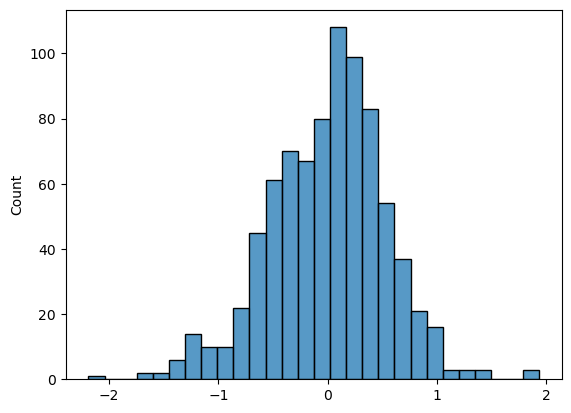

In [6]:
# Histogram of residuals
sns.histplot(x = fit.resid)
plt.show()

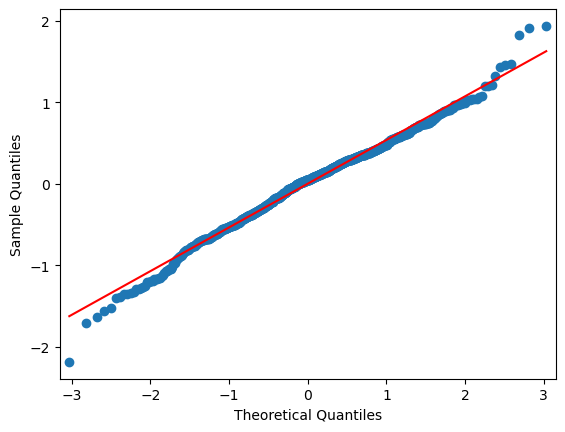

In [7]:
# QQ plot
sm.qqplot(fit.resid, line='s')
plt.show()

I'm comfortable calling this good enough to say that the residuals are normally distributed.

### Mixed Linear Model
As mentioned before, I wanted to account for the correlation within countries. A mixed linear model allows us to do a longitudinal multiple linear regression on the data. It takes into account clusters that form when observations are taken multiple times from the same subject. We can tell that different groups formed different clusters from the pairplot in the EDA, which shows the distribution of variable values differed by region. Because they differed by region, it is reasonable to assume that they differed by country as well, and this is the group that we are going to use here. Year also needs to be included as a variable to account for autocorrelation over time here.

First, I created a model with just the variables of interest:

In [8]:
lmm_inter = smf.mixedlm("log_GDP ~ Year +(log_energy_cons+log_rail_cargo)", df, groups=df["Country"],
                        re_formula="~1").fit()

print(lmm_inter.summary())

           Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   log_GDP
No. Observations:   820       Method:               REML   
No. Groups:         93        Scale:                0.0299 
Min. group size:    1         Log-Likelihood:       45.2410
Max. group size:    12        Converged:            Yes    
Mean group size:    8.8                                    
-----------------------------------------------------------
                Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
-----------------------------------------------------------
Intercept       -8.966    3.638 -2.465 0.014 -16.097 -1.836
Year             0.016    0.002  8.578 0.000   0.012  0.019
log_energy_cons  0.821    0.038 21.786 0.000   0.747  0.895
log_rail_cargo   0.032    0.020  1.600 0.110  -0.007  0.070
Group Var        0.484    0.479                            



Once we account for the differences between countries, increased rail cargo appears to have a positive correlation with GDP. However, its effect is also no longer significant. Let's look at a model that has the interactions as well:

In [9]:
lmm_inter = smf.mixedlm("log_GDP ~ Year + (log_energy_cons+log_rail_cargo)*(urban_per+service_per+democracy)-(urban_per+service_per+democracy)", df, groups=df["Country"],
                        re_formula="~1").fit()

print(lmm_inter.summary())

                 Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:       log_GDP
No. Observations:       820           Method:                   REML   
No. Groups:             93            Scale:                    0.0287 
Min. group size:        1             Log-Likelihood:           39.3498
Max. group size:        12            Converged:                Yes    
Mean group size:        8.8                                            
-----------------------------------------------------------------------
                            Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
-----------------------------------------------------------------------
Intercept                   -6.317    4.014 -1.574 0.116 -14.185  1.551
Year                         0.014    0.002  7.164 0.000   0.010  0.018
log_energy_cons              0.623    0.103  6.037 0.000   0.421  0.826
log_rail_cargo              -0.013    0.050 -0.254 0.800  -0.110  0.085
log_energ

Once country-level effects are accounted for, the effect of rail cargo is found to be insignificant. Democracy still has a cumulative positive correlation with the GDP, but it is much smaller. Once again, we'll go through the regression assumptions.

The data appear to be normal enough based on a histogram of the residuals and the Q-Q plot: 

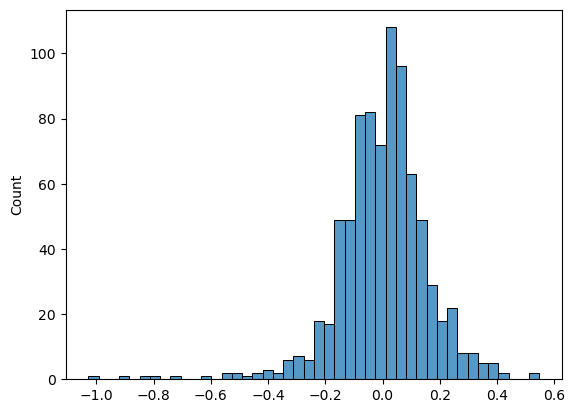

In [10]:
sns.histplot(lmm_inter.resid)
plt.show()

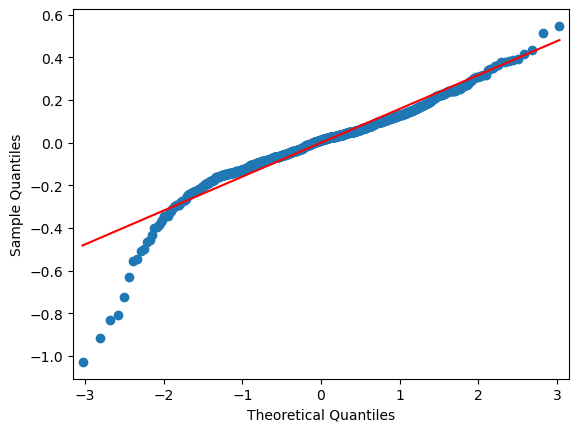

In [11]:
# QQ plot
sm.qqplot(lmm_inter.resid, line='s')
plt.show()

There is a long left tail, but we have enough observations that I don't think it should really matter that much.

More concerning is that, according to a fitted values versus residual plot, our data is still heteroskedastic. 

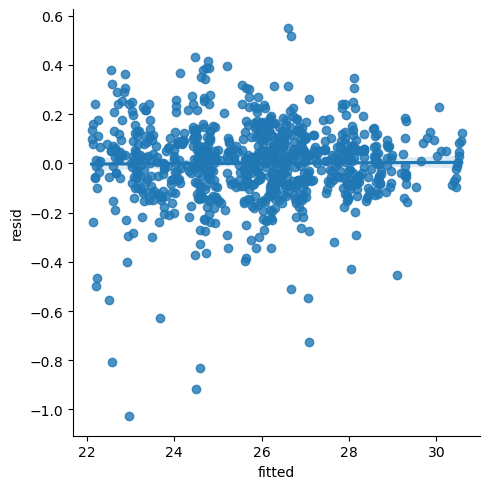

In [12]:
df['fitted'] = lmm_inter.fittedvalues
df['resid'] = lmm_inter.resid
sns.lmplot(data = df, x = 'fitted', y = 'resid')
plt.show()

We can confirm this with a Breusch-Pagan test:

In [13]:
# Conduct the Breusch-Pagan test
names = ['Lagrange multiplier statistic', 'p-value',
         'f-value', 'f p-value']
 
# Get the test result
test_result = sms.het_breuschpagan(lmm_inter.resid, lmm_inter.model.exog)
 
lzip(names, test_result)

[('Lagrange multiplier statistic', 96.27687606428948),
 ('p-value', 8.889448381522433e-17),
 ('f-value', 11.972698618036382),
 ('f p-value', 7.474758802932374e-18)]

With p <0.05, we can reject the null hypothesis and conclude that there is still heteroskedasticity in the data. Unfortunately, the `mixedlm()` function in `statsmodels` doesn't have a way to deal with this, despite the fact that `statsmodels` has provided the `ols()` function with a way to do so. While our estimators will not be biased by this, this means our standard errors will be incorrect.

# Conclusion
While there remain some problems with our data, we are still able to draw some conclusions. The first is that while energy consumption has a clear correlation with GDP, rail cargo volume does not seem to add much information to a model that already includes energy consumption and may in fact have a negative correlation with GDP. This suggests that the Li Keqiang index is a flawed measure for the modern economy. While rail cargo volume seems to indicate that more goods are being produced and transported, it also shows that the economy relies on industrial production rather than a strong service or financial industry that produces more value-add. 

Additionally, in countries with higher levels of democracy, energy consumption had an even higher effect on GDP than in countries with low levesl of democracy. Since I had expected non-democracies to be overreporting their GDP, I had expected energy consumption to have a lower effect on GDP in countries with higher levels of democracy. As mentioned above, this may suggest that democracies have intrinsically better economies or that they use their resources (such as electricity) for projects that result in stronger development. While percentage of GDP from services and percentage of population in urban areas both had statistically significant interactions with the variables of interest, their effect size was overall very small compared to that of the interactions with levels of democracy. This suggests that they had little impact on the efficacy of the index.

# Discussion
Throughout this project, I have raised some issues with the data and with the models being used.
### Data Issues
In the end, most of the data used was from Europe alone. This biases the results of the project toward the behavior of Western economies. This is problematic because European economies are generally more developed and ship things shorter distances. The GDP of less developed and larger countries, such as those of Asia and Africa, would *a priori*, be believed to be better predicted by rail cargo volume. This means that the effect of rail cargo volume may not be detectable, simply because the kinds of economies that rely on it have not been examined adequately. 
Additionally, many of the non-European countries in the analysis had missing values. Consider the following graph from the previous blog post:

Text(0.5, 1.0, 'Countries with missing values by region')

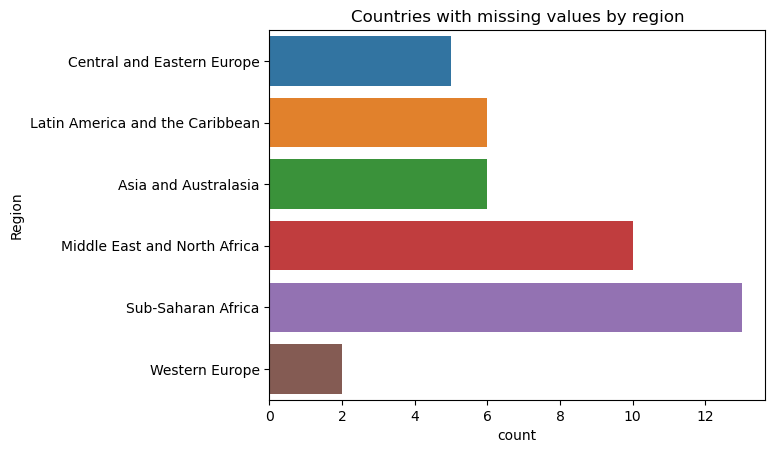

In [14]:
vc = df['Country'].value_counts() < 12
vc = vc[vc]

dropped_countries = df.loc[df['Country'].isin(vc.index)][['Country','Region']].drop_duplicates()
dropped_countries['Region'].value_counts()
ax = sns.countplot(data = dropped_countries, y = 'Region')
ax.set_title('Countries with missing values by region')

Non-European countries, especially in Africa, were the countries which were most likely to have some data missing. This means that the countries whose economies were *a priori* believed to be best represented by measures of rail cargo volume were also the most likely to be themselves inadequately represented. This is especially problematic when you look at countries that have fewer than four data points:

Text(0.5, 1.0, 'Countries with less than four values by region')

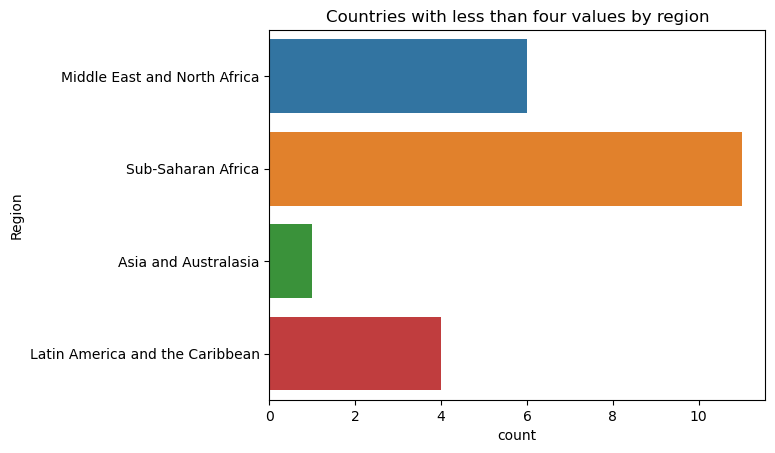

In [15]:
vc = df['Country'].value_counts() < 4
vc = vc[vc]

dropped_countries = df.loc[df['Country'].isin(vc.index)][['Country','Region']].drop_duplicates()
dropped_countries['Region'].value_counts()
ax = sns.countplot(data = dropped_countries, y = 'Region')
ax.set_title('Countries with less than four values by region')

Africa and the Middle East are extremely overrepresented among these countries, and in fact most of the African and Middle Eastern countries with missing values have fewer than four total values. Because three is the minimum number of data points needed to create a linear regression, this suggests that the data simply does not exist to make an adequate conclusion based on these countries. Meanwhile, Europe and North America are represented strongly in the data and have the most influence on the data results show. This has data ethics implications: is it really ethical to make conclusions about economic indicators like the Li Keqiang Index based on data that prioritizes wealthy, Western economies? It's possible that the woefully inadequate data being gathered on the Global South is leading to misconceptions about those economies.  

### Model Issues
As I mentioned above, the `mixedlm()` function in the `statsmodels` package for Python doesn't appear to have any way to deal with heteroskedasticity, despite this presumably being a relatively common problem for statisticians using mixed linear models to face. This means that the standard errors of this analysis, thus decisions about whether a particular variable in a model is statistically significant or not, are skewed. Additionally, one glaring omission from this model is the third element of the Li Keqiang index: bank loan volume. As far as I could tell, there is no public data on this for any country in the world, and it would be extremely difficult to get it in most countries. Li Keqiang could do so because he had developed his economic indicators while he was the effective governor of his province in a country where the banks are directly controlled by the government. Most other researchers, however, do not have such a luxury. 

All of this, combined with the data issues above, limits the usability of the mixed linear model for evaluating the Li Keqiang index.